<a href="https://colab.research.google.com/github/saumyadash9/Saumya-Dash-Rossmann-Sales-Prediction---Capstone-Project.ipynb/blob/main/Saumya_Dash_Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# **Importing required libraries and data files**

In [30]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
lin= LinearRegression()
import warnings    
warnings.filterwarnings('ignore')

In [31]:
#Mounting google drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Read csv file
df_sales = pd.read_csv('/content/drive/MyDrive/Copy of Rossmann Stores Data.csv')
df_stores = pd.read_csv('/content/drive/MyDrive/Copy of store.csv')

# **Data Exploration**

In [33]:
# checking top 5 rows of the sales dataset
df_sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [34]:
# checking top 5 rows of the stores dataset
df_stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [35]:
# checking shape of sales dataset
df_sales.shape

(1017209, 9)

In [36]:
# checking shape of stores dataset
df_stores.shape

(1115, 10)

In [37]:
#We can see that the number of rows in both dataset differs significantly. 
#We only have data for 1115 stores in the stores dataset, which is only 0.1%, of the total number of sales data given in the sales dataset

1115/1017209*100

0.10961365855001283

In [38]:
#checking for null values and the data types of all the columns in sales dataset
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


*   We can see there are no Null Values in the sales dataset




In [39]:
#checking for null values and the data types of all the columns in stores dataset.
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [40]:
#counting the number of null values in each column in stores dataset
df_stores.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

**Observation**

There are four columns which contains null values those are following:


*  **CompetitionDistance-** This is the distance from the nearest competitor store.We will check the distribution of the data according to which we will determine which among mean, median or mode will be suitable to replace the null value with.
*   **CompetitionOpenSinceMonth-** gives the around which the nearest competitor was opened, mode of the column would tell us the most occuring month

* **CompetitionOpenSinceYear- **bold text** **gives the year around which the nearest competitor was opened, mode of the column would tell us the most occuring month

* **Promo2SinceWeek, Promo2SinceYear and PromoInterval** -are NaN wherever Promo2 is 0 or False as can be seen in the first look of the dataset. They can be replaced with 0.


# **Data Cleaning**

 **Treating the Null Values**

In [41]:
#checking for unique values in CompetitionOpenSinceYear
df_stores.CompetitionOpenSinceYear.unique()

array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
         nan, 2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961.,
       1995., 2001., 1990., 1994., 1900., 1998.])

In [42]:
#checking for unique values in CompetitionOpenSinceMonth
df_stores.CompetitionOpenSinceMonth.unique()

array([ 9., 11., 12.,  4., 10.,  8., nan,  3.,  6.,  5.,  1.,  2.,  7.])

In [43]:
#counting for competition stores being open for each month 
df_stores.CompetitionOpenSinceMonth.value_counts() 

9.0     125
4.0      94
11.0     92
3.0      70
7.0      67
12.0     64
10.0     61
6.0      50
5.0      44
2.0      41
8.0      39
1.0      14
Name: CompetitionOpenSinceMonth, dtype: int64

In [44]:
#counting for competition stores being open for each year 
df_stores.CompetitionOpenSinceYear.value_counts() 

2013.0    83
2012.0    82
2014.0    70
2005.0    62
2010.0    55
2008.0    54
2009.0    54
2011.0    54
2007.0    48
2006.0    47
2015.0    38
2002.0    27
2004.0    22
2003.0    19
2001.0    16
2000.0    10
1999.0     8
1990.0     5
1995.0     2
1994.0     2
1961.0     1
1900.0     1
1998.0     1
Name: CompetitionOpenSinceYear, dtype: int64

In [45]:
#checking the percentage of missing values in both Competition Open since Month and Year
354/1115*100

31.748878923766817

In [46]:
#filling null values in Promo2 Since week, year and Promo Interval with 0
df_stores['Promo2SinceWeek'] = df_stores['Promo2SinceWeek'].fillna(0)

In [47]:
df_stores.Promo2SinceWeek.isnull().sum()

0

In [48]:
df_stores['Promo2SinceYear'] = df_stores['Promo2SinceYear'].fillna(0)

In [49]:
df_stores['PromoInterval'] = df_stores['PromoInterval'].fillna(0)

In [50]:
df_stores.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

In [51]:
df_stores['PromoInterval'] = df_stores['PromoInterval'].fillna(0)

In [52]:
#filling the null values with median for CompetitionDistance column and mode for CompetitionOpenSince Year and Month
df_stores["CompetitionDistance"].fillna(df_stores["CompetitionDistance"].median(),inplace=True)
df_stores["CompetitionOpenSinceMonth"].fillna(df_stores["CompetitionOpenSinceMonth"].mode()[0],inplace=True)
df_stores["CompetitionOpenSinceYear"].fillna(df_stores["CompetitionOpenSinceYear"].mode()[0],inplace=True)

In [53]:
df_stores = df_stores.dropna(how='all', axis=1)

In [54]:
# we can df_stores.isnull().sum()

In [55]:
#Let's merge the two dataset to proceed with our prediction process 
new_dataset = pd.merge(df_sales,df_stores, how = 'left', on = 'Store')

In [56]:
#checking for nullvalues in the new dataset 
new_dataset.isnull().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [57]:
#checking additional information such as null values and data types of the columns in the new dataset
new_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1017209 non-null  float64
 12  CompetitionOpenSinceMonth  1017209 non-null  float64
 13  CompetitionO

In [58]:
# looking for some statistical description of our main dataset using describe function
new_dataset.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,5.422021e+03,7.787777e+00,2.010060e+03,5.005638e-01,1.164767e+01,1.007011e+03
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,7.706918e+03,2.778755e+00,5.340757e+00,4.999999e-01,1.532393e+01,1.005877e+03
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01,1.000000e+00,1.900000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,7.100000e+02,6.000000e+00,2.008000e+03,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,2.325000e+03,9.000000e+00,2.012000e+03,1.000000e+00,1.000000e+00,2.009000e+03
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,6.880000e+03,9.000000e+00,2.013000e+03,1.000000e+00,2.200000e+01,2.012000e+03
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,7.586000e+04,1.200000e+01,2.015000e+03,1.000000e+00,5.000000e+01,2.015000e+03


 **Data Manipulation**

In [59]:
# eliminating the rows where the stores are closed, i.e. rows with Open ==0, as they are not relevant to predict sales.
new_dataset = new_dataset[new_dataset.Open == 1]

In [60]:
#Since we have removed all the rows with Open == 0, we are only left with rows where stores are Open.
# Hence dropping the Open Column from our dataset
new_dataset.drop("Open",axis=1, inplace= True)

In [61]:
# checking for rows with zero sales 
new_dataset["Store"][new_dataset["Sales"]==0].sum()

31460

In [62]:
# calculating the percentage of rows with zero sales in our dataset
round((new_dataset["Store"][new_dataset["Sales"]==0].sum()/new_dataset["Store"].sum()*100) ,4)

0.0067

In [63]:
# We can see that there are only 0.0067% data with zero sales so eliminating those instances from our datatset.
new_dataset = new_dataset[new_dataset.Sales!=0]

In [64]:
#checking for information of our dataset
new_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Date                       844338 non-null  object 
 3   Sales                      844338 non-null  int64  
 4   Customers                  844338 non-null  int64  
 5   Promo                      844338 non-null  int64  
 6   StateHoliday               844338 non-null  object 
 7   SchoolHoliday              844338 non-null  int64  
 8   StoreType                  844338 non-null  object 
 9   Assortment                 844338 non-null  object 
 10  CompetitionDistance        844338 non-null  float64
 11  CompetitionOpenSinceMonth  844338 non-null  float64
 12  CompetitionOpenSinceYear   844338 non-null  float64
 13  Promo2                     8

In [65]:
# adding a weekend column in our dataset with 0,1 values if weekend or weekdays respectively
Weekend = []
for row in new_dataset['DayOfWeek']:
    if row < 6 :    Weekend.append(0)        
      
    else:           Weekend.append(1)

In [66]:
#adding the weekend column in our dataset
new_dataset['Weekend'] = pd.Series(Weekend)

In [67]:
#checking top 5 rows of dataset
new_dataset.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Weekend
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,0.0
1,2,5,2015-07-31,6064,625,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",0.0
2,3,5,2015-07-31,8314,821,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",0.0
3,4,5,2015-07-31,13995,1498,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,0.0
4,5,5,2015-07-31,4822,559,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,0.0


In [68]:
# making a list for all the continuous independent variables 
continuous_variable_list = ["Customers","CompetitionDistance"]

In [69]:
# making a list for all the categorical independent variables 
categorical_variable_list = ['DayOfWeek','Promo','StateHoliday','SchoolHoliday','StoreType',
                             'Assortment','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2',
                             'Promo2SinceWeek','Promo2SinceYear','PromoInterval']

In [70]:
#defining a function to extract date, month and year from date column
def extract_year(x):
    return int(str(x)[:4])

def extract_month(x):
    return int(str(x)[5:7])

def extract_month_year(x):
    return (str(x)[:7])

In [71]:
#adding date, month and year columns ith respected extracted values in dataset
new_dataset['Date'] = new_dataset['Date'].apply(extract_month_year)
df_sales['Date'] = df_sales['Date'].apply(extract_month_year)
new_dataset['Year']  = new_dataset['Date'].apply(extract_year)
new_dataset['Month'] = new_dataset['Date'].apply(extract_month)
df_sales['Year']  = df_sales['Date'].apply(extract_year)
df_sales['Month'] = df_sales['Date'].apply(extract_month)

In [72]:
# checking all the unique values for catergorical independent variables
for i in categorical_variable_list:
  print(f'Unique values of {i} column are {new_dataset[i].unique()} ')
  print("\n")

Unique values of DayOfWeek column are [5 4 3 2 1 7 6] 


Unique values of Promo column are [1 0] 


Unique values of StateHoliday column are ['0' 'a' 'b' 'c' 0] 


Unique values of SchoolHoliday column are [1 0] 


Unique values of StoreType column are ['c' 'a' 'd' 'b'] 


Unique values of Assortment column are ['a' 'c' 'b'] 


Unique values of CompetitionOpenSinceMonth column are [ 9. 11. 12.  4. 10.  8.  3.  6.  5.  1.  2.  7.] 


Unique values of CompetitionOpenSinceYear column are [2008. 2007. 2006. 2009. 2015. 2013. 2014. 2000. 2011. 2010. 2005. 1999.
 2003. 2012. 2004. 2002. 1961. 1995. 2001. 1990. 1994. 1900. 1998.] 


Unique values of Promo2 column are [0 1] 


Unique values of Promo2SinceWeek column are [ 0. 13. 14.  1. 45. 40. 26. 22.  5.  6. 10. 31. 37.  9. 39. 27. 18. 35.
 23. 48. 36. 50. 44. 49. 28.] 


Unique values of Promo2SinceYear column are [   0. 2010. 2011. 2012. 2009. 2014. 2015. 2013.] 


Unique values of PromoInterval column are [0 'Jan,Apr,Jul,Oct' 'Feb,May,Aug

In [73]:
#Counting stores present in each Store Types
new_dataset.StoreType.value_counts()

a    457042
d    258768
c    112968
b     15560
Name: StoreType, dtype: int64

In [74]:
#Adding a column for average sales for each storetype in the dataset
Average_Storewise_sales = new_dataset.groupby('StoreType')['Store'].mean()

In [75]:
# printing the average sales for each storetype
print(Average_Storewise_sales)

StoreType
a    560.087410
b    555.930077
c    608.222337
d    533.887432
Name: Store, dtype: float64


In [76]:
x = ['Store','DayOfWeek','Customers','Promo','SchoolHoliday','CompetitionDistance','CompetitionOpenSinceYear','Sales']

## **Data Vizualization**

### **Univariate Analysis**

*** Data Vizualization for Continuous Variables***

In [77]:
# Plotting distribution plot for each continuous variables : Customers,Sales and Competition Distance

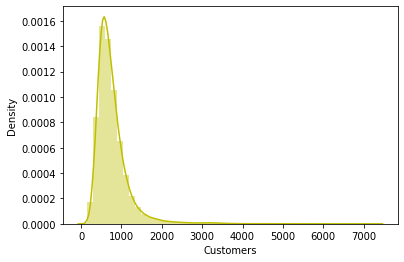

In [78]:
sns.distplot(new_dataset['Customers'], color="y")
plt.show()

*From the above probability density plot we can see that the 'Customers' is not normally distributed, it's a bit right skewed.To treat the skweness we are using Square root transformation for the particular variable.*

In [79]:
new_dataset["sqrt_Customers"] = np.sqrt(new_dataset["Customers"])

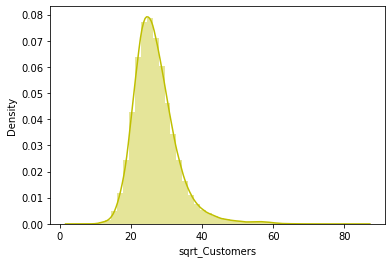

In [80]:
sns.distplot(new_dataset['sqrt_Customers'], color="y")
plt.show()

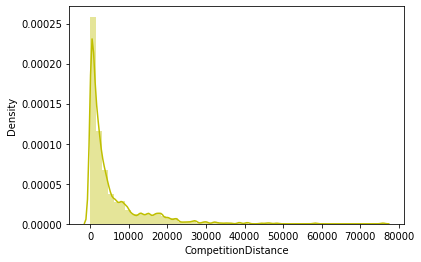

In [81]:
sns.distplot(new_dataset['CompetitionDistance'], color="y")
plt.show()

In [82]:
new_dataset["log_CompetitionDistance"] = np.log(new_dataset["CompetitionDistance"])

*From the above probability density plot we can see that the 'Competition Distance' is not normally distributed, it's moderately right skewed.To treat the skweness we are using Log transformation for the particular variable.*

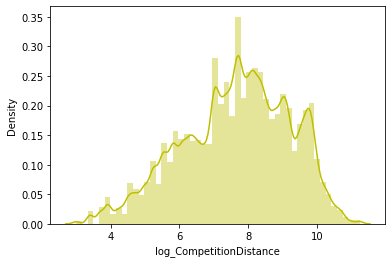

In [83]:
sns.distplot(new_dataset["log_CompetitionDistance"], color="y")
plt.show()

*Checking the distribution of the Target Variable:Sales using distplot*

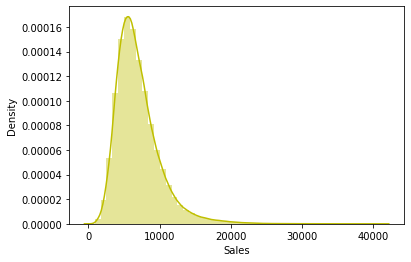

In [84]:
sns.distplot(new_dataset['Sales'], color="y")
plt.show()

*From the above probability density plot we can see that the targe 'Sales' is not normally distributed, it's a bit rightly skewed.To treat the skweness we are using Square root transformation for the particular variable.*

In [85]:
new_dataset["sqrt_Sales"] = np.sqrt(new_dataset["Sales"])

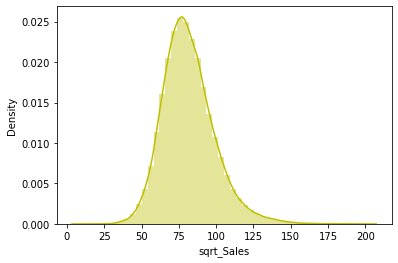

In [86]:
sns.distplot(new_dataset['sqrt_Sales'], color="y")
plt.show()

*We can See Square Root Transformation did a great job! Our Target Variable is normally distributed and is ready to be used in our Model.*

### **Data Visualization for Categorical Independent Variables**

In [87]:
#creating a dataframe out of the categorical variable list constructed above
cat_df = new_dataset[categorical_variable_list]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e91eb4090>,
      dtype=object)

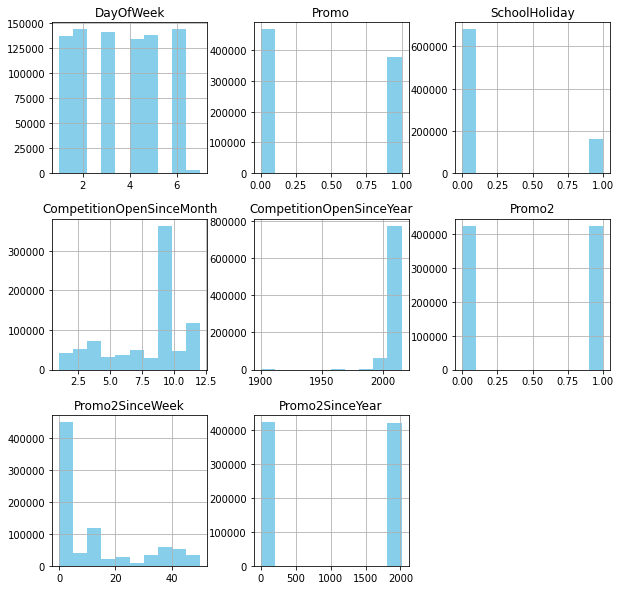

In [88]:
# Univariate analysis of Categorical Variables in the dataset using Histograms.
cat_df.hist(color = 'skyblue', figsize= (10,10))

### **Bivariate Analysis**

Store Type and Sales

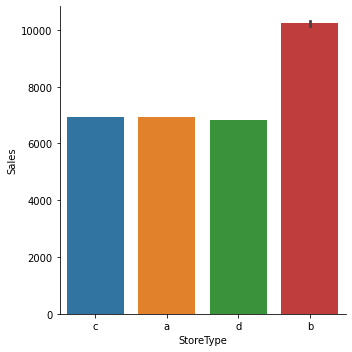

In [89]:
# Plotting the sales for each Store Type using categorical barplot
sns.catplot(data=new_dataset, x="StoreType", y="Sales", kind="bar")

Customers and Sales

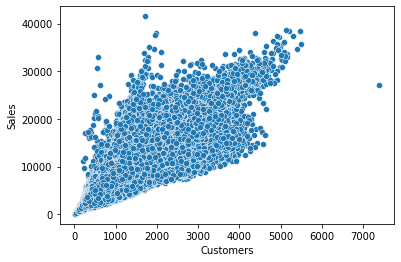

In [90]:
# Plotting the relationship between Sales and Number of Customers using Scatterplot
sns.scatterplot(x=new_dataset['Customers'], y=new_dataset['Sales'])

Competition Distance and Sales

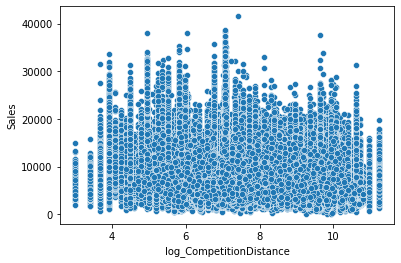

In [91]:
# Plotting the relationship between Sales and Competition Distance using Scatterplot
sns.scatterplot(x=new_dataset['log_CompetitionDistance'], y=new_dataset['Sales'])

Date and Sales: Monthly Sales

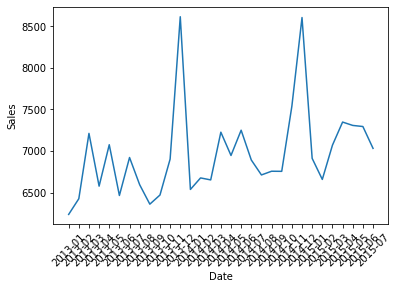

<Figure size 720x720 with 0 Axes>

In [92]:
#Monthly trend of sales using lineplot
sns.lineplot(data=new_dataset.groupby('Date')['Sales'].mean().reset_index(), x='Date', y='Sales')
plt.xticks(rotation= 45)
plt.figure(figsize=(10,10))
plt.show()

State Holiday and Sales

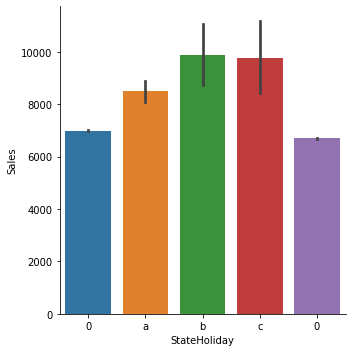

In [93]:
# Plotting categorical bar plot for count of Sales on each State Holidays
sns.catplot(data=new_dataset, x="StateHoliday", y="Sales", kind="bar")

School Holiday and Sales

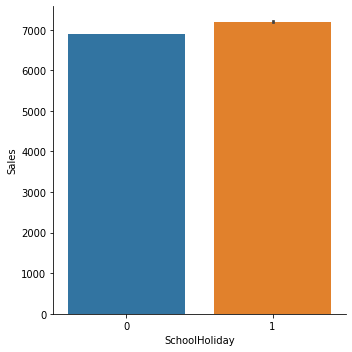

In [94]:
# Plotting categorical bar plot for count of Sales in each School Holiday
sns.catplot(data=new_dataset, x="SchoolHoliday", y="Sales", kind="bar")

Competition Open Since Year and Sales

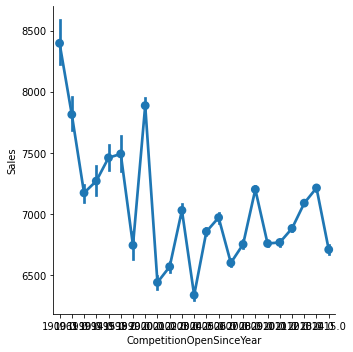

In [95]:
#plotting line graph for showing trend in sales due to Competition open since year
sns.catplot(data=new_dataset, x="CompetitionOpenSinceYear", y="Sales", kind="point")

In [96]:
#adding a column average customer sales by dividing Sales with Customers
new_dataset["Avg_Customer_Sales"] = new_dataset.Sales / new_dataset.Customers

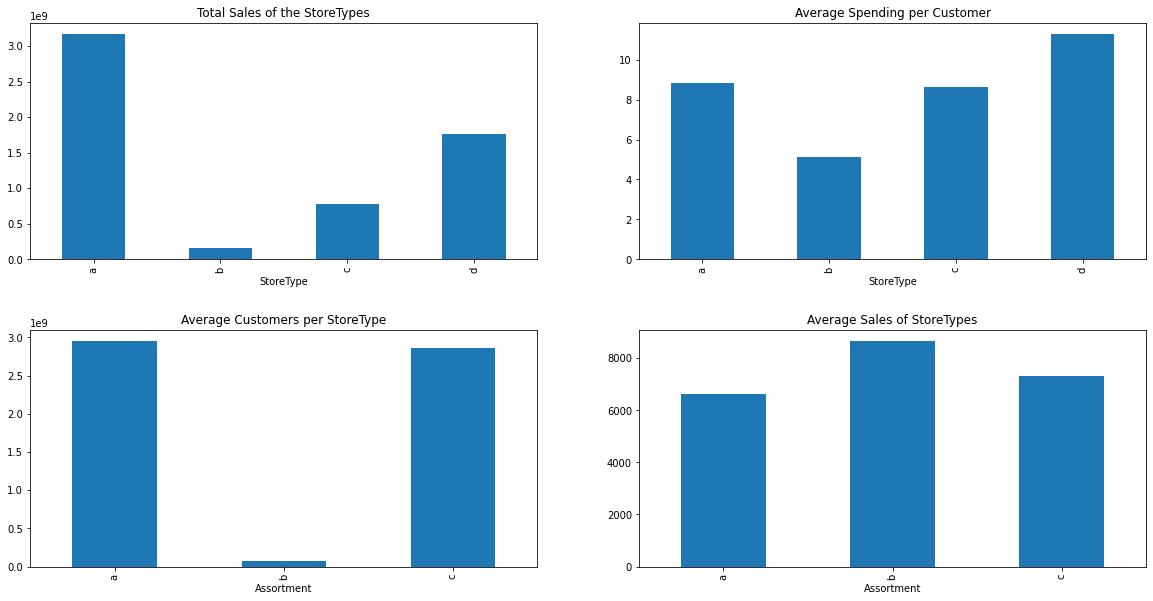

In [97]:
#plotting Histograms showing Total Sales of Store Types, Average Spending per Customer, Average Customer per Store Type and Average sales of Store Types using the mentioned formulae
f, ax = plt.subplots(2, 2, figsize = (20,10))

new_dataset.groupby("StoreType")["Sales"].sum().plot(kind = "bar", ax = ax[0,0], title = "Total Sales of the StoreTypes")
new_dataset.groupby("StoreType")["Avg_Customer_Sales"].mean().plot(kind = "bar", ax = ax[0,1], title = "Average Spending per Customer")
new_dataset.groupby("Assortment")["Sales"].sum().plot(kind = "bar", ax = ax[1,0], title = "Average Customers per StoreType")
new_dataset.groupby("Assortment")["Sales"].mean().plot(kind = "bar", ax = ax[1,1], title = "Average Sales of StoreTypes")

plt.subplots_adjust(hspace = 0.3)
plt.show()

Promo and Promo2 with Sales

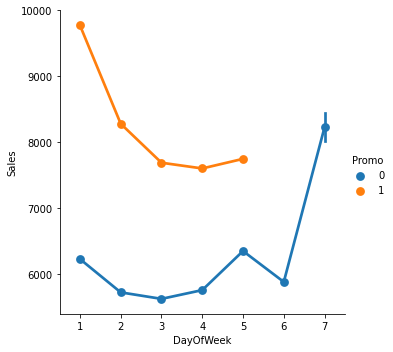

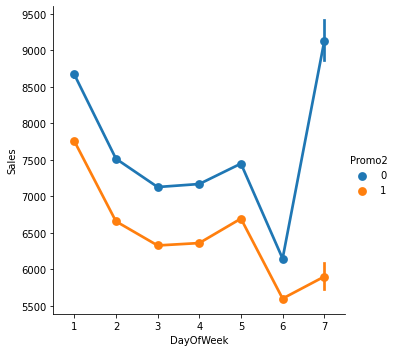

In [98]:
#plotting day wise sales with and without promo using factorplot
sns.factorplot(data =new_dataset, x = "DayOfWeek", y = "Sales", hue = "Promo")
sns.factorplot(data = new_dataset, x = "DayOfWeek", y = "Sales", hue = "Promo2")

Store Type Assortment level with Sales

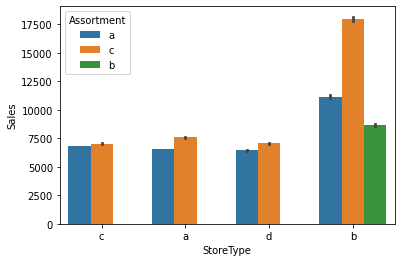

In [99]:
#Plotting sales and assortment level for each store type using barplot
sns.barplot(x=new_dataset["StoreType"],y=new_dataset['Sales'],hue=new_dataset["Assortment"])

State Holiday and Average sales

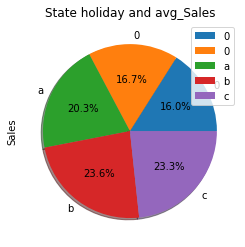

In [100]:
#Plotting percentage of Average sales in each state holiday using pie chart
new_dataset.groupby("StateHoliday")["Sales"].mean().plot.pie(title='State holiday and avg_Sales', legend=True, autopct='%1.1f%%', shadow=True)
plt.show()

## **Multivariate Analysis**

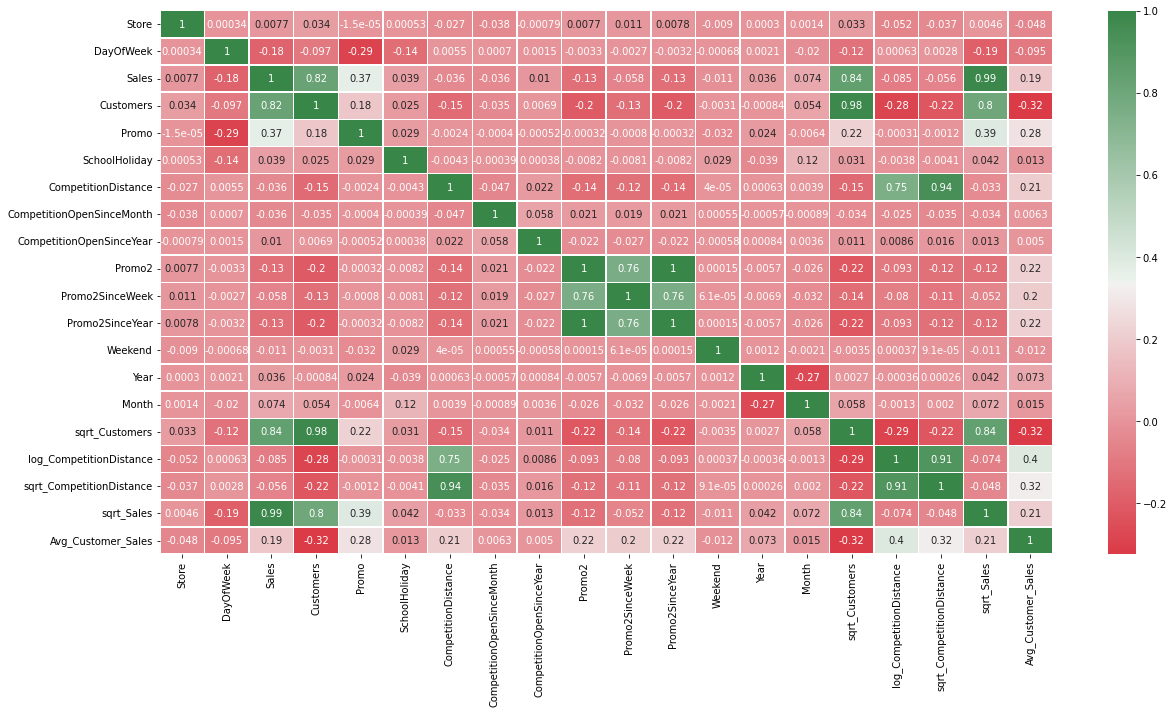

In [ ]:
#Checking correlation matrix of the whole dataset using Correlation Heatmap
f, ax = plt.subplots(figsize = (20, 10))
sns.heatmap(new_dataset.corr(),ax = ax, annot=True, cmap=sns.diverging_palette(10, 133, as_cmap=True), linewidths=0.5)

**Feature Engineering**

In [ ]:
new_dataset.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceYear,PromoInterval,Weekend,Year,Month,sqrt_Customers,log_CompetitionDistance,sqrt_CompetitionDistance,sqrt_Sales,Avg_Customer_Sales
0,1,5,2015-07,5263,555,1,0,1,c,a,...,0.0,0,0.0,2015,7,23.558438,7.146772,35.637059,72.546537,9.482883
1,2,5,2015-07,6064,625,1,0,1,a,a,...,2010.0,"Jan,Apr,Jul,Oct",0.0,2015,7,25.000000,6.345636,23.874673,77.871689,9.702400
2,3,5,2015-07,8314,821,1,0,1,a,a,...,2011.0,"Jan,Apr,Jul,Oct",0.0,2015,7,28.653098,9.556055,118.869677,91.181138,10.126675
3,4,5,2015-07,13995,1498,1,0,1,c,c,...,0.0,0,0.0,2015,7,38.704005,6.429719,24.899799,118.300465,9.342457
4,5,5,2015-07,4822,559,1,0,1,a,a,...,0.0,0,0.0,2015,7,23.643181,10.305948,172.945078,69.440622,8.626118


In [ ]:
# One hot encoding
new_dataset= pd.get_dummies(new_dataset,columns=['StoreType','Assortment','Year'])

In [ ]:
new_dataset.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,...,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Year_2013,Year_2014,Year_2015
0,1,5,2015-07,5263,555,1,0,1,1270.0,9.0,...,0,0,1,0,1,0,0,0,0,1
1,2,5,2015-07,6064,625,1,0,1,570.0,11.0,...,1,0,0,0,1,0,0,0,0,1
2,3,5,2015-07,8314,821,1,0,1,14130.0,12.0,...,1,0,0,0,1,0,0,0,0,1
3,4,5,2015-07,13995,1498,1,0,1,620.0,9.0,...,0,0,1,0,0,0,1,0,0,1
4,5,5,2015-07,4822,559,1,0,1,29910.0,4.0,...,1,0,0,0,1,0,0,0,0,1


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
calc_vif(new_dataset[[i for i in new_dataset.describe().columns if i not in ['Store','Sales','Weekend','sqrt_Sales']]])

,variables,VIF
0,DayOfWeek,1.125964e+00
1,Customers,2.978450e+01
2,Promo,1.375262e+00
3,SchoolHoliday,1.034508e+00
4,CompetitionDistance,3.044894e+01
5,CompetitionOpenSinceMonth,1.015617e+00
6,CompetitionOpenSinceYear,1.017601e+00
7,Promo2,8.000669e+05
8,Promo2SinceWeek,2.560855e+00
9,Promo2SinceYear,7.995095e+05


In [ ]:
new_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  int64  
 2   Date                       844338 non-null  object 
 3   Sales                      844338 non-null  int64  
 4   Customers                  844338 non-null  int64  
 5   Promo                      844338 non-null  int64  
 6   StateHoliday               844338 non-null  object 
 7   SchoolHoliday              844338 non-null  int64  
 8   CompetitionDistance        844338 non-null  float64
 9   CompetitionOpenSinceMonth  844338 non-null  float64
 10  CompetitionOpenSinceYear   844338 non-null  float64
 11  Promo2                     844338 non-null  int64  
 12  Promo2SinceWeek            844338 non-null  float64
 13  Promo2SinceYear            8

In [ ]:
new_dataset["StateHoliday"] =new_dataset["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

In [ ]:
y= new_dataset["sqrt_Sales"]
x1= new_dataset[['DayOfWeek','log_CompetitionDistance','sqrt_Customers','StateHoliday', 'SchoolHoliday','Promo','Promo2','StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d','Assortment_a', 'Assortment_b',
       'Assortment_c', 'Year_2013', 'Year_2014', 'Year_2015','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear','Promo2SinceWeek']]

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
# std = StandardScaler()
# X_train_std = std.fit_transform(X_train)
# X_test_std = std.transform(X_test)

In [ ]:
x=sm.add_constant(x1)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sqrt_Sales   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                 3.127e+05
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        06:20:40   Log-Likelihood:            -2.7739e+06
No. Observations:              844338   AIC:                         5.548e+06
Df Residuals:                  844320   BIC:                         5.548e+06
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        24.8771      1.395     17.831      0.000      22.143      27.612
DayOfWeek                    -0.1074      0.004    -24.840      0.000      -0.116      -0.099
log_CompetitionDistance       1.5960      0.005    320.106      0.000       1.586       1.606
sqrt_Customers                2.7270      0.001   1973.339      0.000       2.724       2.730
StateHoliday                  0.7250      0.216      3.357      0.001       0.302       1.148
SchoolHoliday                 0.3583      0.018     19.897      0.000       0.323       0.394
Promo                         5.9921      0.015    393.886      0.000       5.962       6.022
Promo2                        1.4403      0.022     64.794      0.000       1.397       1.484
StoreType_a                   8.2318      0.349     23.588      0.000       7.548       8.916
StoreType_b                  -5.6270      0.355    -15.854      0.000      -6.323      -4.931
StoreType_c                   7.2875      0.349     20.888      0.000       6.604       7.971
StoreType_d                  14.9848      0.350     42.847      0.000      14.299      15.670
Assortment_a                 14.7857      0.466     31.713      0.000      13.872      15.700
Assortment_b                 -6.1208      0.469    -13.045      0.000      -7.040      -5.201
Assortment_c                 16.2122      0.468     34.673      0.000      15.296      17.129
Year_2013                     7.5217      0.465     16.171      0.000       6.610       8.433
Year_2014                     8.1054      0.465     17.424      0.000       7.194       9.017
Year_2015                     9.2500      0.465     19.885      0.000       8.338      10.162
CompetitionOpenSinceMonth    -0.0395      0.003    -15.501      0.000      -0.044      -0.035
CompetitionOpenSinceYear     -0.0326      0.001    -24.517      0.000      -0.035      -0.030
Promo2SinceWeek               0.0543      0.001     76.580      0.000       0.053       0.056
==============================================================================
Omnibus:                    51355.070   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           126267.687
Skew:                           0.369   Prob(JB):                         0.00
Kurtosis:                       4.745   Cond. No.                     1.66e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.23e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x1,y,test_size=0.3, random_state=1)

In [ ]:
scaler=StandardScaler()

x_train1 = scaler.fit_transform(x_train)
x_test1 = scaler.transform(x_test)

In [ ]:
linreg = lin.fit(x_train1, y_train)

In [ ]:
# definte RMSE function
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(x, y):
    return sqrt(mean_squared_error(x, y))

# definte MAPE function
def mape(x, y): 
    return np.mean(np.abs((x - y) / x)) * 100  
  
# get cross validation scores 
y_predicted = linreg.predict(x_train1)
y_test_predicted = linreg.predict(x_test1)

print("Regresion Model Score" , ":" , linreg.score(x_train1, y_train) , "," ,
      "Out of Sample Test Score" ,":" , linreg.score(x_test1, y_test))
print("Training RMSE", ":", rmse(y_train, y_predicted),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted))
print("Training MAPE", ":", mape(y_train, y_predicted),
      "Testing MAPE", ":", mape(y_test, y_test_predicted))

Regresion Model Score : 0.8632730979707379 , Out of Sample Test Score : 0.8620825434853236
Training RMSE : 6.460913572181647 Testing RMSE : 6.474678884573082
Training MAPE : 6.2395040946099485 Testing MAPE : 6.264130235846424


**Lasso**

In [ ]:
from sklearn.linear_model import LassoLars
las = LassoLars(alpha=0.3, fit_intercept=False, normalize=True)
lasreg = las.fit(x_train, y_train)
print("Regresion Model Score" , ":" , lasreg.score(x_train, y_train) , "," ,
      "Out of Sample Test Score" ,":" , lasreg.score(x_test, y_test))

yd_predicted = lasreg.predict(x_train1)
yd_test_predicted = lasreg.predict(x_test1)

print("Training RMSE", ":", rmse(y_train, y_predicted),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted))
print("Training MAPE", ":", mape(y_train, y_predicted),
      "Testing MAPE", ":", mape(y_test, y_test_predicted))

Regresion Model Score : 0.8330340494151067 , Out of Sample Test Score : 0.8322935097293892
Training RMSE : 6.460913572181647 Testing RMSE : 6.474678884573082
Training MAPE : 6.2395040946099485 Testing MAPE : 6.264130235846424


**Ridge**

In [ ]:
from sklearn.linear_model import BayesianRidge
rdg = BayesianRidge()
rdgreg = rdg.fit(x_train1, y_train)
# validation
print("Regresion Model Score" , ":" , rdgreg.score(x_train1, y_train) , "," ,
      "Out of Sample Test Score" ,":" , rdgreg.score(x_test1, y_test))

yd_predicted = rdgreg.predict(x_train1)
yd_test_predicted = rdgreg.predict(x_test1)

print("Training RMSE", ":", rmse(y_train, y_predicted),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted))
print("Training MAPE", ":", mape(y_train, y_predicted),
      "Testing MAPE", ":", mape(y_test, y_test_predicted))

Regresion Model Score : 0.8632790800960524 , Out of Sample Test Score : 0.8620839324953599
Training RMSE : 6.460913572181647 Testing RMSE : 6.474678884573082
Training MAPE : 6.2395040946099485 Testing MAPE : 6.264130235846424


**Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(min_samples_leaf=20)
treereg = tree.fit(x_train1, y_train)
print("Regresion Model Score" , ":" , treereg.score(x_train1, y_train) , "," ,
      "Out of Sample Test Score" ,":" , treereg.score(x_test1, y_test))

yl_predicted = treereg.predict(x_train1)
yl_test_predicted = treereg.predict(x_test1)
print("Training RMSE", ":", rmse(y_train, y_predicted),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted))
print("Training MAPE", ":", mape(y_train, y_predicted),
      "Testing MAPE", ":", mape(y_test, y_test_predicted))

Regresion Model Score : 0.9637035071087259 , Out of Sample Test Score : 0.9550024020303911
Training RMSE : 6.460913572181647 Testing RMSE : 6.474678884573082
Training MAPE : 6.2395040946099485 Testing MAPE : 6.264130235846424


**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rdf = RandomForestRegressor(n_estimators=30)
rdfreg = rdf.fit(x_train1, y_train)
print("Regresion Model Score" , ":" , rdfreg.score(x_train1, y_train) , "," ,
      "Out of Sample Test Score" ,":" , rdfreg.score(x_test1, y_test))   

y_predicted = rdfreg.predict(x_train1)
y_test_predicted = rdfreg.predict(x_test1)

print("Training RMSE", ":", rmse(y_train, y_predicted),
      "Testing RMSE", ":", rmse(y_test, y_test_predicted))
print("Training MAPE", ":", mape(y_train, y_predicted),
      "Testing MAPE", ":", mape(y_test, y_test_predicted))

Regresion Model Score : 0.9954791430965407 , Out of Sample Test Score : 0.9722278644850099
Training RMSE : 1.1748362139991144 Testing RMSE : 2.9054489723801296
Training MAPE : 1.0342530788303632 Testing MAPE : 2.6323419072345455


Text(0.5, 0, 'Relative Importance')

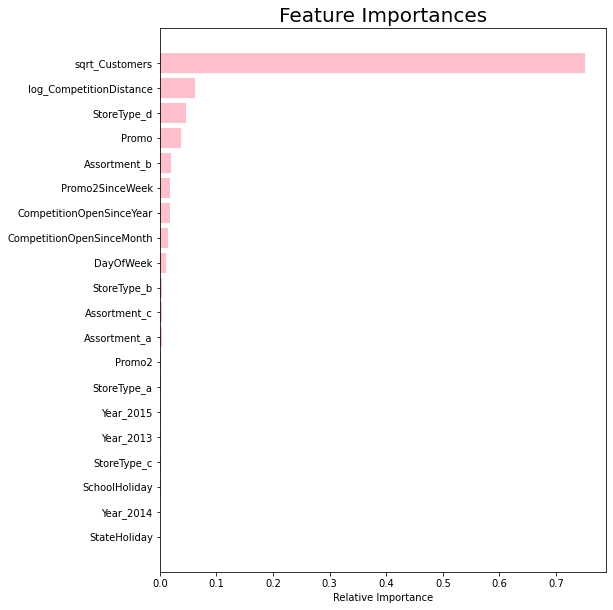

In [ ]:
features = x_train.columns
importances = rdfreg.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,10))
plt.title('Feature Importances', fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='pink', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')